# ARIM情報活用講座：　ケモインフォマテックス応用編　
# 第2回：　類似度計算と次元削減

## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第一章　1.3 データの可視化　－次元削減ー

## 本編の目標
RDKitを使って分子記述子の扱い方と、その記述子から分子構造と性能の類似度の相関性をPCAやt-SNE、UMAPで可視化するフローを示します。
* 構造の類似性（RDKit記述子の類似性）は、タニモト係数を使って計算します。
* 次元削減の演習として、構造の類似性のタニモト係数を種々の次元削減のアルゴリズム（PCA, t-SNE,　UMAP）から空間に水溶解度を付置させて相関性を可視化します。

## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいています。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit
!pip install umap-learn

!git clone https://github.com/ARIM-Academy/Advanced_Tutorial_4.git
%cd Advanced_Tutorial_4

## 1.分子構造データの読み込み　（P.11）

### 汎用ライブラリのインポート

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み
ここでは「data/dataset」フォルダーにあるdelaney-processed.csvをpandasの`read_csv()`からデータフレーム（DataFrame）オブジェクトとして変数dfに格納します。dfは1128化合物に対して10の特徴量からなるデータ行列となっていることが確かめられます。

In [2]:
df = pd.read_csv('./data/dataset/delaney-processed.csv')
df['mol']=df['smiles'].apply(Chem.MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x000002DDE55...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x000002DDE55...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x000002DDE55...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x000002DDE55...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x000002DDE55...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x000002DDE56...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002DDE56...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x000002DDE56...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002DDE56...


## 2.分子の類似度計算 （タニモト係数）　（底本P12）
### 作業の流れ
分子構造の類似性を判断するタニモト距離の算出手順について学んでゆきましょう。主な手順は以下の通りです。

1. 水溶解度のファイルをダウンロードする　（省略）
1. Morganフィンガープリントを0/1で256桁として取り出す
1. Morganフィンガープリントを基準にしてタニモト距離を計算する

### タニモト係数とは

タニモト係数は、化学構造の類似性を評価するための指標として広く使用される重要な指標です。2つの化合物のバイナリフィンガープリントを比較し、共通のフィンガープリントのビット数を分母に、2つのフィンガープリントのビットごとの共通の1の数を分子に用いて計算されます。タニモト係数は、0から1の範囲の値を取り、値が1に近いほど化合物の類似性が高いことを示します。

具体的には、2つの集合 `A` と `B` のタニモト係数は次のように計算されます：

```
Tanimoto coefficient = (|A ∩ B|) / (|A| + |B| - |A ∩ B|)

```

ここで、|A| は集合 A の要素数、|B| は集合 B の要素数、|A ∩ B| は2つの集合の共通要素の数を表します。タニモト係数は、0から1の値を取り、値が1に近いほど2つの集合は類似していることを示します。



一方、似た指標としてジャカード距離（Jaccard distance）があります。ジャカード距離は、2つの集合の共通要素の数を、それぞれの集合の合計要素数から差し引いた値を、それぞれの集合の合計要素数で割って計算します。ジャカード距離は次のように表されます：

```
Jaccard distance = 1 - (|A ∩ B|) / (|A| + |B| - |A ∩ B|)
```

ジャカード距離は、0から1の範囲の値を取り、値が0に近いほど2つの集合は類似していることを示します。

なお、ケモインフォマテックスではタニモト距離として次のような定義がありますので、ジャカード距離とタニモト距離は同義です。

```
Tanimoto distance = 1 - Tanimoto coefficient
```

このように、タニモト係数とジャカード距離（タニモト距離）は、1から他の値を引いたもので表現されるため、互いに対応関係にあります。

これより、タニモト係数とジャカード距離は、共通の要素を持つ2つの集合の類似性を測定する際に使用される類似度指標です。タニモト係数は類似度を示し、値が1に近いほど類似性が高いことを示します。ジャカード距離は距離を示し、値が0に近いほど類似性が高いことを示します。両者は相補的な関係にあり、一方の値を計算すれば他方の値を推定することも可能です。

### Morganフィンガープリント

delaney溶解度に含まれる1128化合物について、半径3でビットベクトル256のMorganフィンガープリントを三項演算子の方法で計算し出力します。

In [8]:
#非推奨のAllChem.GetMorganFingerprintAsBitVectでの出力方法

X = np.matrix([AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=256) for m in df['mol']])
X

In [9]:
X.shape

(1128, 256)

### タニモト距離の計算
1128化合物の総当たりのタニモト距離の計算はscipyに含まれているpdist関数を使って行えます。

In [10]:
from scipy.spatial.distance import pdist, squareform

distances = pdist(X, metric='jaccard')

# 距離ベクトルを元の行列形式に変換
D = squareform(distances)
D.shape

(1128, 1128)

このようにすることで、`distance_matrix`は元のデータセットのデータポイント間の距離行列を表します。

In [11]:
D

array([[0.        , 0.8125    , 0.86486486, ..., 0.91139241, 0.95384615,
        0.8988764 ],
       [0.8125    , 0.        , 0.84313725, ..., 0.92982456, 0.97619048,
        0.80327869],
       [0.86486486, 0.84313725, 0.        , ..., 0.91304348, 0.89655172,
        0.89285714],
       ...,
       [0.91139241, 0.92982456, 0.91304348, ..., 0.        , 0.86666667,
        0.87719298],
       [0.95384615, 0.97619048, 0.89655172, ..., 0.86666667, 0.        ,
        0.97777778],
       [0.8988764 , 0.80327869, 0.89285714, ..., 0.87719298, 0.97777778,
        0.        ]])

【解説】scipyを用いた様々な距離の計算方法
* `scipy.spatial.distance`モジュールから`pdist`と`squareform`をインポートすることで、データセット内のデータポイント間の距離を計算する機能を利用することができます。

* `pdist`関数は、与えられたデータセット内のデータポイント間の距離を計算します。データセットは通常、2次元または多次元の配列として表され、各行が個々のデータポイントを表します。距離計算には、さまざまな距離尺度（ユークリッド距離、マンハッタン距離、コサイン距離、ジャカード距離など）を使用することができます。`pdist`関数は、計算された距離を圧縮したベクトル形式で返します。

* `squareform`関数は、`pdist`関数によって得られた距離ベクトルを元の行列形式に変換します。具体的には、距離ベクトルを対称行列に変換します。この行列は、元のデータセット内の各データポイントの間の距離を表現します。対称行列の要素は、元のデータセットの対応するデータポイント間の距離に対応しています。


* 以下は、`pdist`と`squareform`を使用してデータセット内のデータポイント間の距離行列を計算し、それを元の行列形式に変換する一般的な使用例です。

```python
from scipy.spatial.distance import pdist, squareform

# データセットの準備
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# データポイント間の距離行列を計算
distances = pdist(data, metric='euclidean')

# 距離ベクトルを元の行列形式に変換
distance_matrix = squareform(distances)
```

### タニモト距離の可視化

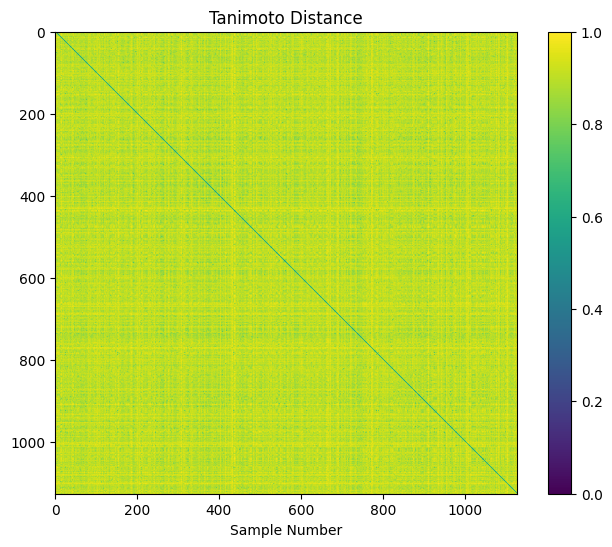

In [12]:
# 図1.4　タニモト距離を用いた化合物データの性状確認
# 図 1.4(a)　タニモト距離の可視化

fig = plt.subplots(figsize=(8, 6))
plt.imshow(D)
plt.colorbar()

plt.title('Tanimoto Distance')
plt.xlabel('Sample Number')

#plt.savefig('./results/eda/tanimotocoef.png')

plt.show()

1128化合物のうち、化合物IDが0番～40番までの範囲で相関図を見てみることにしましょう。

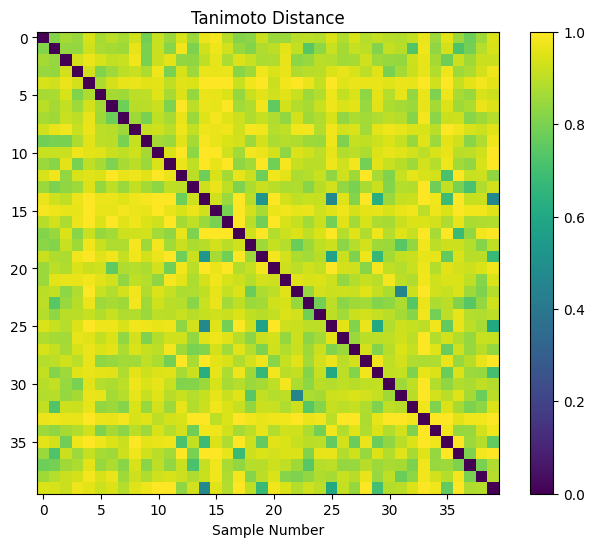

In [13]:
fig = plt.subplots(figsize=(8, 6))

subset = D[0:40, 0:40]

plt.imshow(subset)
plt.colorbar()

plt.title('Tanimoto Distance')
plt.xlabel('Sample Number')

#plt.savefig('./results/eda/tanimotocoef.png')

plt.show()

### 化合物の類似性検索

参照分子との類似性を計算します。以下は、Morganフィンガープリントを使用して`DataStructs`モジュールにある`FingerprintSimilarity`メソッドからタニモト距離を計算する例です。

ここでは、下記の化合物をDelaneyの1128の化合物の中からタニモト距離で最も類似性のある化合物を検索します。Morganフィンガープリントとして半径2としてセットします。

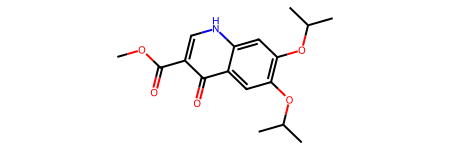

In [14]:
ref_smiles = 'COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O'
ref_mol = Chem.MolFromSmiles(ref_smiles)
ref_mol

In [16]:
ref_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,2)
ref_fps

[15:15:50] DEPRECATION WARNING: please use MorganGenerator


In [17]:
# Create Morgan fingerprint generator
#fp = fg.GetMorganGenerator(radius=2, fpSize=2048)

# Generate Morgan fingerprints
#bulk_fps = [fp.GetFingerprintAsNumPy(m) for m in df['mol']]

In [18]:
bulk_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in df['mol']]

[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerator
[15:15:53] DEPRECATION WARNING: please use MorganGenerat

三項演算子の方法を使って1128化合物とのタニモト距離を計算を総当たりに行い、得られた距離を'Tanimoto_Similarity'のカラム名で追加します。

In [19]:
from rdkit import DataStructs

similarity = [DataStructs.FingerprintSimilarity(ref_fps,x) for x in bulk_fps]
df['Tanimoto_Similarity'] = similarity

In [20]:
df['Tanimoto_Similarity']

0       0.080000
1       0.157895
2       0.054545
3       0.062500
4       0.022727
          ...   
1123    0.021277
1124    0.101695
1125    0.072727
1126    0.071429
1127    0.155172
Name: Tanimoto_Similarity, Length: 1128, dtype: float64

リスト上位8番目までの目的化合物とのタニモト距離を`PandasTools`で見てみましょう。

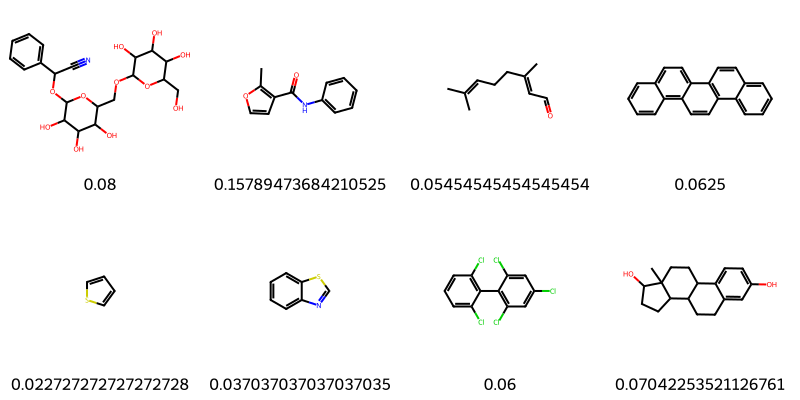

In [21]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
PandasTools.FrameToGridImage(df.head(8), legendsCol="Tanimoto_Similarity", molsPerRow=4)

類似度を昇降順に並べると

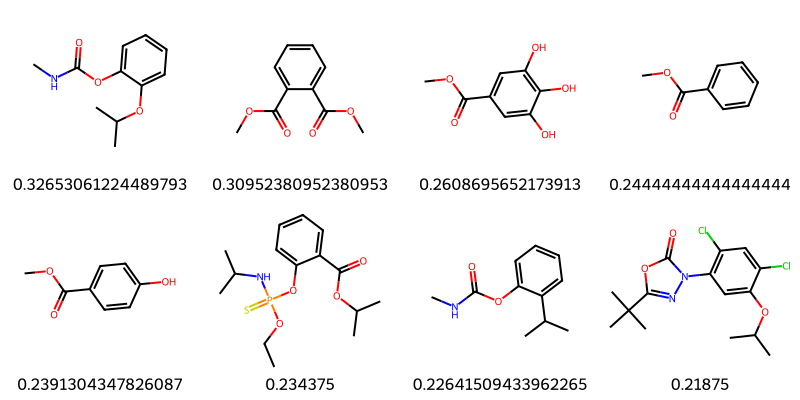

In [22]:
esol_data = df.sort_values(['Tanimoto_Similarity'], ascending=False)
PandasTools.FrameToGridImage(esol_data.head(8), legendsCol="Tanimoto_Similarity", molsPerRow=4)

【留意事項】  
タニモト距離を用いた化合物の類似度検索において、Fingerprintの選択は重要な要素となりますが、下記の留意すべき点があります。

1. フィンガープリントのタイプ:　タニモト距離を計算するためには、比較する化合物のFingerprintが同じタイプとします。異なるタイプのFingerprintを比較することはできません。

2. フィンガープリントのパラメータ:　Fingerprintの計算において、パラメータを変更すると、Fingerprintの特徴が変わり、類似度の計算結果にも影響を及ぼす可能性があります。

3. Fingerprintのビット長:　Fingerprintのビット長は、類似度検索の結果に大きな影響を与えます。ビット長が長い場合、より詳細な情報を持つFingerprintになりますが、計算コストも増加します。

4. 化合物データの特性:　使用するFingerprintの選択は、化合物データの特性に応じて検討する必要があります。例えば、特定のタイプの化合物ライブラリに対して最適なFingerprintが異なる場合があります。

5. フィンガープリントの比較方法:　タニモト距離はFingerprintの類似度を計算する方法の一つですが、他にも類似度指標があります（例：Tanimoto係数、Dice係数、コサイン類似度など）。使用するFingerprintに応じて、適切な類似度指標を選択する必要があります。

これらの留意点を考慮して、タニモト距離を用いた化合物の類似度検索を適切に行うためには、適切なFingerprintの選択とパラメータの調整が重要です。データセットや特定の化合物データに合わせて最適なFingerprintを選ぶことで、より有用な類似度検索結果を得ることができます。

## 3.次元削減　（底本P12）
次元削減の意義と機械学習における活用方法や手法についてまとめます。

1. 次元削減の意義:
   - 高次元のデータにおいて、次元が増えるとデータの可視化や理解が困難になるため、次元削減は重要です。
   - 高次元のデータでは、冗長な情報やノイズが存在することが多く、次元削減によってこれらを取り除くことでデータの質を向上させることができます。
   - 次元削減によってデータの特徴を抽出し、計算の効率化や過学習の軽減など、機械学習モデルの性能向上に寄与することができます。  


2. 機械学習における次元削減の活用方法:
   - 特徴選択（Feature Selection）: 高次元の特徴空間から重要な特徴を選択し、それに基づいてモデルを構築することで、計算効率の向上やモデルの性能向上を図ります。
   - 特徴抽出（Feature Extraction）: 高次元のデータを低次元の新たな特徴空間に射影することで、データの表現を簡素化し、計算効率やモデルの性能向上を図ります。
   - データ可視化: 次元削減はデータの可視化にも利用されます。データを低次元に射影することで、データのクラスタリングや分布の構造を可視化し、洞察を得ることができます。


以下は、代表的な次元削減の手法である主成分分析（PCA）、t-SNE、UMAPの定義と活用方法を表形式でまとめたものです。

| 手法 | 　　線形性　　　 | 定義|
| :---: | :---: |:---: |
| 主成分分析（PCA） |　　線形　　| 元の多次元空間データの情報をできるだけ保持しつつ、<br>データの変動を最大限に捉える主成分空間への射影する手法  |
| t-SNE（t-Distributed Stochastic Neighbor Embedding）|　　 非線形　　　 | 高次元データを低次元空間に埋め込むことで、データ間の類似性や<br>クラスタ構造をできるだけ保持しつつ、可視化を行う手法。|
| UMAP（Uniform Manifold Approximation and Projection）|　　非線形　　　 | 高次元データを低次元のマニフォールド（滑らかな多様体）上に<br>確率的な近似に基づいて埋め込みの最適化を行う手法。|

### 3.1 PCAによる次元削減
scikit-learnライブラリから標準化（StandardScaler）、主成分分析（PCA）、パイプライン（Pipeline）をインポートします。 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#### 主成分分析(PCA)の計算
主成分分析（PCA）においては、異なる尺度や単位を持つ変数間のスケールの違いを取り除くために標準化（または正規化）を行います。  

* StandardScalerは、データを平均0、標準偏差1に変換するための標準化を行うためのクラスです。主成分分析（PCA）を適用する前にデータを標準化する際に使用されます。  

* make_pipelineは、複数の変換器や推定器を組み合わせてパイプラインを構築するためのメソッドで、データの前処理とモデルの学習・予測を一連のステップとして連結させることができます。

ここでは、主成分分析の前にデータの標準化が必要であるため、パイプラインを構築する際にStandardScalerとPCAを組み合わせることを行います。

In [ ]:
pca = make_pipeline(StandardScaler(), PCA())
T_pca = pca.fit_transform(D)

#### 主成分分析(PCA)の寄与率の算出
各主成分が全体の情報をどれくらい説明ができているかを示す「寄与率」をexplained_variance_ratio_から取得します。

In [ ]:
ratio_ = dict(pca.steps)['pca'].explained_variance_ratio_
ratio_

#### 主成分分析(PCA)の可視化
主成分分析（PCA）の結果を可視化するための散布図を作成します。ここでは、主成分分析の結果である主成分スコア（T_pca）の第一主成分と第二主成の2つの主成分を取り出し、またその値の色はy = 'measured log solubility in mols per litre'に基づいて変えています。

In [ ]:
fig = plt.subplots(figsize=(8, 6))

y = df['measured log solubility in mols per litre'].values
plt.scatter(T_pca[:,0],T_pca[:,1], c=y, cmap=plt.cm.seismic)

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

cbar = plt.colorbar()
cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

#### 考察例

1. Tanimoto係数で似ているとされている構造でも、log水溶解度は必ずしも近くならない
1. また、クラスターは特に出来ていないため、データを分ける必要はなさそう

### 3.2 t-SNEによる次元削減

t-SNE（t分布型確率的近傍埋め込み法：t-Distributed Stochastic Neighbor Embedding）は、非線形な次元削減手法の一つ。


**特徴**  
t-SNEは、高次元データの視覚化や特徴の圧縮に使用されます。特に、データの局所的な類似性を維持しつつ、データ間のグローバルな関係を捉えることができる特徴があります。

t-SNEは、主に2つのステップから構成されます。まず、高次元データの類似度行列を作成します。この行列は、各データポイント間の類似度や距離を表現します。通常は、ユークリッド距離やコサイン類似度などが使用されます。

次に、類似度行列を元に、低次元空間への埋め込みを行います。この埋め込みでは、高次元データを2次元または3次元の低次元空間に変換します。この変換により、データのグローバルな構造やクラスタリングのパターンが視覚化されます。

**アルゴリズム**  
t-SNEは、データポイントの位置を定めるために確率的なアプローチを使用しており、データポイント間の類似度に基づいて確率分布を作成します。高次元データでは、近くにあるデータポイントの類似度が高いことが多いため、近くのデータポイント間の確率は高くなります。同様に、低次元空間でも近くにあるデータポイント間の確率が高いように調整されます。この確率分布の最適化には、確率的勾配降下法が使用されます。

**利点**  
t-SNEの利点は、特にデータの局所的な構造やクラスタリングの特徴を視覚的に表現できる点です。また、次元削減によってデータの可視化やクラスタリングの際に、有用な特徴を抽出することができます。

**制約**  
t-SNEにはいくつかの制約もあります。例えば、計算コストが高いため、大規模なデータセットでは時間がかかる場合があります。また、異なる実行ごとに結果が異なることがあるため、再現性に注意する必要があります。さらに、t-SNEは非線形次元削減手法であるため、高次元データのグローバルな構造を正確に反映しづらい場合があります。

#### ライブラリ  
scikit-learnライブラリからt-SNE（t-distributed Stochastic Neighbor Embedding）をインポートします。

In [ ]:
from sklearn.manifold import TSNE

#### t-SNEの計算  
TSNEクラスのインスタンスを作成します。n_componentsパラメータは、埋め込まれる空間の次元数を指定します。ここでは2次元に埋め込むためにn_componentsを2に設定しています。す。

In [ ]:
tsne = TSNE(n_components=2, random_state=66)
T_tsne = tsne.fit_transform(D)

#### t-SNEの可視化

In [ ]:
fig = plt.subplots(figsize=(8, 6))

y = df['measured log solubility in mols per litre'].values
plt.scatter(T_tsne[:,0],T_tsne[:,1], c=y, cmap=plt.cm.seismic)

cbar = plt.colorbar()
cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

### 3.3 UMAPによる次元削減

Uniform Manifold Approximation and Projection (UMAP) は、高次元データを低次元に次元削減し、データの構造やパターンを視覚化するためのデータ分析技術です。以下の３つの仮定に基づいています。

* データはリーマン多様体上で均等に分布している。
* リーマン計量は局所的に一定である。
* 多様体は局所的に連結している。

これらの仮定から、多様体を位相的な構造でモデル化することが可能です。埋め込みは、最も近いぼんやりとした位相的な構造を持つデータの低次元射影を探索することによって見つけます。基礎となる数学の詳細については、以下のArXivの論文に記載されています。

McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03  

また、pythonにおけるライブラリは、以下から参照できます。  
https://umap-learn.readthedocs.io/en/latest/n/latest/  

#### ライブラリ
umap-learn（Uniform Manifold Approximation and Projection）ライブラリからUMAP（Uniform Manifold Approximation and Projection）をインポートします。

In [ ]:
from umap import UMAP

#### UMAPの計算  
UMAPクラスのインスタンスを作成します。n_componentsパラメータは、埋め込まれる空間の次元数を指定します。ここでは2次元に埋め込むためにn_componentsを2に設定しています。

In [ ]:
umap = UMAP(n_components=2, random_state=0)
T_umap = umap.fit_transform(D)

#### UMAPの可視化

In [ ]:
fig = plt.subplots(figsize=(8, 6))

y = df['measured log solubility in mols per litre'].values
plt.scatter(T_umap[:,0],T_umap[:,1], c=y, cmap=plt.cm.seismic)

cbar = plt.colorbar()
cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()